##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RNN を使ったテキスト分類

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

このテキスト分類チュートリアルでは、感情分析のために [IMDB 映画レビュー大型データセット](http://ai.stanford.edu/~amaas/data/sentiment/) を使って [リカレントニューラルネットワーク](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) を訓練します。

## 設定

In [2]:
# !pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

`matplotlib` をインポートしグラフを描画するためのヘルパー関数を作成します。

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 入力パイプラインの設定

IMDB 映画レビュー大型データセットは*二値分類*データセットです。すべてのレビューは、*好意的(positive)* または *非好意的(negative)* のいずれかの感情を含んでいます。

[TFDS](https://www.tensorflow.org/datasets) を使ってこのデータセットをダウンロードします。

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

 このデータセットの `info` には、エンコーダー(`tfds.features.text.SubwordTextEncoder`) が含まれています。

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


このテキストエンコーダーは、任意の文字列を可逆的にエンコードします。必要であればバイトエンコーディングにフォールバックします。

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 訓練用データの準備

次に、これらのエンコード済み文字列をバッチ化します。`padded_batch` メソッドを使ってバッチ中の一番長い文字列の長さにゼロパディングを行います。

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: **TensorFlow 2.2** から、padded_shapes は必須ではなくなりました。デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします。

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## モデルの作成

`tf.keras.Sequential` モデルを構築しましょう。最初に Embedding レイヤーから始めます。Embedding レイヤーは単語一つに対して一つのベクトルを収容します。呼び出しを受けると、Embedding レイヤーは単語のインデックスのシーケンスを、ベクトルのシーケンスに変換します。これらのベクトルは訓練可能です。（十分なデータで）訓練されたあとは、おなじような意味をもつ単語は、しばしばおなじようなベクトルになります。

このインデックス参照は、ワンホットベクトルを `tf.keras.layers.Dense` レイヤーを使って行うおなじような演算に比べてずっと効率的です。

リカレントニューラルネットワーク（RNN）は、シーケンスの入力を要素を一つずつ扱うことで処理します。RNN は、あるタイムステップでの出力を次のタイムステップの入力へと、次々に渡していきます。

RNN レイヤーとともに、`tf.keras.layers.Bidirectional` ラッパーを使用することができます。このラッパーは、入力を RNN 層の順方向と逆方向に伝え、その後出力を結合します。これにより、RNN は長期的な依存関係を学習できます。

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

訓練プロセスを定義するため、Keras モデルをコンパイルします。

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## モデルの訓練

In [31]:
print(type(train_dataset))
print(type(test_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>


In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 66s 170ms/step - loss: 0.6295 - accuracy: 0.5863 - val_loss: 0.4382 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 64s 163ms/step - loss: 0.3262 - accuracy: 0.8643 - val_loss: 0.3442 - val_accuracy: 0.8594
Epoch 3/10
391/391 [==============================] - 65s 166ms/step - loss: 0.2434 - accuracy: 0.9065 - val_loss: 0.3322 - val_accuracy: 0.8646
Epoch 4/10
391/391 [==============================] - 65s 167ms/step - loss: 0.1769 - accuracy: 0.9355 - val_loss: 0.3711 - val_accuracy: 0.8635
Epoch 6/10
391/391 [==============================] - 65s 166ms/step - loss: 0.1607 - accuracy: 0.9431 - val_loss: 0.3454 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 65s 166ms/step - loss: 0.1444 - accuracy: 0.9492 - val_loss: 0.3941 - val_accuracy: 0.8547
Epoch 8/10
391/391 [==============================] - 65s 166ms/step - loss: 0.1327 - accuracy: 0.9540 - val_loss: 0.4032 - val_ac

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 26s 65ms/step - loss: 0.4515 - accuracy: 0.8490
Test Loss: 0.45145758986473083
Test Accuracy: 0.8489599823951721


上記のモデルはシーケンスに適用されたパディングをマスクしていません。パディングされたシーケンスで訓練を行い、パディングをしていないシーケンスでテストするとすれば、このことが結果を歪める可能性があります。理想的にはこれを避けるために、 [マスキング](../../guide/keras/masking_and_padding)を使うべきですが、下記のように出力への影響は小さいものでしかありません。 

予測値が 0.5 以上であればポジティブ、それ以外はネガティブです。

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.32947785]]


In [20]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.6423665]]


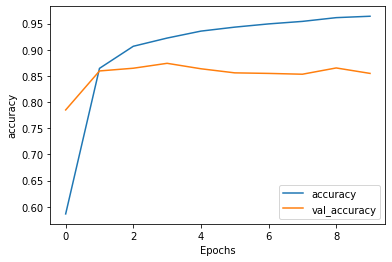

In [21]:
plot_graphs(history, 'accuracy')

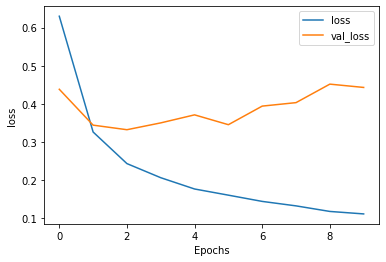

In [22]:
plot_graphs(history, 'loss')

## 2つ以上の LSTM レイヤーを重ねる

Keras のリカレントレイヤーには、コンストラクタの `return_sequences` 引数でコントロールされる2つのモードがあります。

* それぞれのタイムステップの連続した出力のシーケンス全体（shape が `(batch_size, timesteps, output_features)` の3階テンソル）を返す。
* それぞれの入力シーケンスの最後の出力だけ（shape が `(batch_size, output_features)` の2階テンソル）を返す。

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 113s 289ms/step - loss: 0.6644 - accuracy: 0.5365 - val_loss: 0.5021 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 109s 279ms/step - loss: 0.3891 - accuracy: 0.8354 - val_loss: 0.3646 - val_accuracy: 0.8349
Epoch 3/10
391/391 [==============================] - 110s 281ms/step - loss: 0.2785 - accuracy: 0.8945 - val_loss: 0.3338 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 109s 278ms/step - loss: 0.2234 - accuracy: 0.9212 - val_loss: 0.3459 - val_accuracy: 0.8708
Epoch 5/10
391/391 [==============================] - 109s 279ms/step - loss: 0.1885 - accuracy: 0.9375 - val_loss: 0.3596 - val_accuracy: 0.8698
Epoch 6/10
391/391 [==============================] - 109s 279ms/step - loss: 0.1633 - accuracy: 0.9479 - val_loss: 0.3960 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 109s 278ms/step - loss: 0.1452 - accuracy: 0.9564 - val_loss: 0.4265 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391/391 [==============================] - 107s 275ms/step - loss: 0.0948 - accuracy: 0.9752 - val_loss: 0.5236 - val_accuracy: 0.8573


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 45s 115ms/step - loss: 0.5215 - accuracy: 0.8553
Test Loss: 0.5215113162994385
Test Accuracy: 0.8553199768066406


In [27]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.775194]]


In [28]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.1454139]]


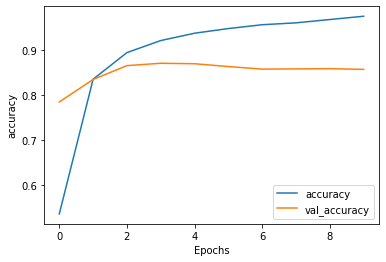

In [29]:
plot_graphs(history, 'accuracy')

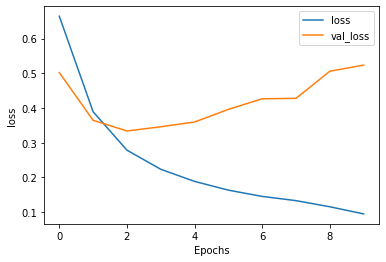

In [30]:
plot_graphs(history, 'loss')

[GRU レイヤー](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)など既存のほかのレイヤーを調べてみましょう。

カスタム RNN の構築に興味があるのであれば、[Keras RNN ガイド](../../guide/keras/rnn.ipynb) を参照してください。